In [1]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client, progress
import dask.array as da
import numpy as np
import pandas as pd
import zarr
import allel
import sys
import ag3
import psutil
from humanize import naturalsize
import numba

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from ag3 import GenomeFigure

In [3]:
n_workers = 20

In [4]:
# cluster setup
cluster = KubeCluster()
cluster.scale_up(n_workers)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.33.122.87:36467
distributed.scheduler - INFO -   dashboard at:                     :8787


In [5]:
# dask client setup
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-a6e8f0ee-22b2-11eb-876f-6a5003b01edc
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.122.87:36467 Dashboard: /user/nicholasharding/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
# grab data from release
v3 = ag3.release_data()

In [21]:
meta_all = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [22]:
import yaml

In [23]:
# load population groups
population_definitions = pd.read_csv("../content/population_definitions.csv", index_col=0)

In [24]:
# load karyotype data
kt = pd.read_csv("../content/tables/karyotype_status_2La.csv", index_col=0)

In [25]:
meta_combined = pd.concat([meta_all, kt, population_definitions], axis=1)

In [32]:
# order is important...
assert (meta_all.index == meta_combined.index).all()

In [26]:
count_ = meta_combined.groupby(["sample_set", "sampling_group", "species_gambcolu_arabiensis"]).size()
count_by_loc = pd.pivot_table(count_.reset_index(), values=0, index=["sample_set", "sampling_group"], columns="species_gambcolu_arabiensis", fill_value=0)

In [27]:
count_

sample_set    sampling_group           species_gambcolu_arabiensis
AG1000G-AO    ANG_1_coluzzii_2009      gamb_colu                       81
AG1000G-BF-A  BUF_1_coluzzii_2012      gamb_colu                       82
              BUF_1_gambiae_2012       gamb_colu                       99
AG1000G-BF-B  BUF_1_coluzzii_2014      gamb_colu                       53
              BUF_1_gambiae_2014       gamb_colu                       46
AG1000G-BF-C  BUF_2_gambiae_2004       gamb_colu                       13
AG1000G-CD    DRC_1_gambiae_2015       gamb_colu                       76
AG1000G-CF    CAR_1_coluzzii_1994      gamb_colu                       13
              CAR_1_gambiae_1994       gamb_colu                       53
AG1000G-CI    CIV_1_coluzzii_2012      gamb_colu                       80
AG1000G-CM-A  CMN_5_gambiae_2009       gamb_colu                       97
              CMN_6_gambiae_2009       gamb_colu                      110
              CMN_7_gambiae_2009       gamb_c

In [29]:
sites_to_investigate= (("UGA_2_arabiensis_2012", "UGA_2_gambiae_2012"),
                       ("KEN_1_arabiensis_2012", "KEN_1_gambiae_2000"),
                       ("TZA_1_arabiensis_2015", "TZA_1_gambiae_2015"),)
sites_to_investigate

(('UGA_2_arabiensis_2012', 'UGA_2_gambiae_2012'),
 ('KEN_1_arabiensis_2012', 'KEN_1_gambiae_2000'),
 ('TZA_1_arabiensis_2015', 'TZA_1_gambiae_2015'))

In [41]:
def equally_accessible_chunks(is_accessible, window_size=50_000):
    
    if not isinstance(is_accessible, np.ndarray):
        is_accessible = np.array(is_accessible)
    
    cumsum = np.cumsum(is_accessible)
    z = ((cumsum % window_size) == 0) & (cumsum >= window_size)

    # only select cells that are multiples of window size **and** are not followed by another cell that contains the window size.
    same_follows = np.diff(z.astype(int), append=0) == 0

    ix = np.where(z & ~same_follows)[0] + 1

    _chunks = np.diff(ix, prepend=0)
    
    return tuple(_chunks), _chunks.sum()

In [42]:
@numba.njit
def dist_block(a, masked, ix, jx):
    
    """
    a: n_alts array
    masked: 1D mask of the same size in 0 axis.
    ix: indicies of the first population
    jx: indicies of the second population
    
    """
    
    diff_sum = np.zeros((ix.shape[0], jx.shape[0]), dtype=np.int32)
    diff_denom = np.zeros((ix.shape[0], jx.shape[0]), dtype=np.int32)
    
    for x in range(a.shape[0]):
        
        i_counter = 0

        # if site filtered by mask
        if not masked[x]:
            continue
    
        for i in ix:
            
            # if i is missing, do not bother to loop through j.
            if a[x, i] < 0:
                continue
            
            j_counter = 0

            for j in jx:

                # if j is missing continue with next j
                if a[x, j] < 0:
                    continue

                else:
                    diff_sum[i_counter, j_counter] += abs(a[x, i] - a[x, j])
                    diff_denom[i_counter, j_counter] += 2

                j_counter += 1

            i_counter += 1
            
    out = diff_sum / diff_denom

    return np.expand_dims(out, axis=0)

In [43]:
chromosomes = ["2L", "2R", "3L", "3R", "X"]

In [44]:
# compress by both, and give new indicies?

In [45]:
# pre fill indices of interest
# only consider homkaryotypic inverted form.
ix_species = {}
for arab_group, gambiae_group in sites_to_investigate:

    arab_loc = meta_combined.sampling_group == arab_group
    gamb_loc = (meta_combined.sampling_group == gambiae_group) & (meta_combined.kt_2La == 2)

    ix_species[arab_group, gambiae_group] = arab_loc, gamb_loc


In [53]:
loc.shape

(2784,)

In [52]:
gamb_loc.shape

(2784,)

In [55]:
pd_dict = {}
pos_dict = {}

for chrom in chromosomes:
    pd_dict[chrom] = {}
    
    # load sampleset independent data
    mask = v3.load_mask(chrom, 'gamb_colu_arab')
    chunk_sizes, end = equally_accessible_chunks(mask)
    
    # reshape and rechunk mask
    maskrc = mask[:end].reshape((-1, 1)).rechunk((chunk_sizes, (1,)))
    
    # load positions, and compute midpoints
    posi = v3.load_variants(chrom)

    midpoints = da.map_blocks(
        lambda y: np.median(y).reshape((1, 1)), 
        posi[:end].reshape((-1, 1)).rechunk((chunk_sizes, 1)),
        chunks=(1, 1)).compute().squeeze()

    pos_dict[chrom] = midpoints
    
    # this doesn't handle multiallelic sites...
    g = v3.load_sample_set_calldata(chrom, v3.all_wild_sample_sets)

    for (arab_group, gambiae_group), (arab_loc, gamb_loc) in ix_species.items():
        
        loc = arab_loc.values | gamb_loc.values
        gs = allel.GenotypeDaskArray(g).compress(loc, axis=1)
        y = gs.to_n_alt(fill=-1)
        
        # find the relevant indices in the resulting block...
        ix_gambcolu = np.where(np.compress(loc, gamb_loc.values))[0]
        ix_arab = np.where(np.compress(loc, arab_loc.values))[0]
        assert (ix_gambcolu.shape[0] + ix_arab.shape[0]) == loc.sum()
        
        # rechunk n_alts to ensure correct size
        yrc = y[:end].rechunk((chunk_sizes, y.shape[1]))

        q = da.map_blocks(
            dist_block, yrc, maskrc, dtype=np.float32, 
            chunks=(1, ix_arab.shape[0], ix_gambcolu.shape[0]), 
            drop_axis=(1,), new_axis=[1, 2], ix=ix_arab, jx=ix_gambcolu)

        pairwise_diff = q.compute()

        pd_dict[chrom][arab_group] = np.percentile(pairwise_diff, (0, 1, 5, 25, 50, 75, 95, 99, 100), axis=(1, 2))

In [65]:
def draw_introgression_relative(chrom, ax, data, location=None):

    minimum = data[chrom][location][0]
    maximum = data[chrom][location][-1]
    
    pos = pos_dict[chrom]
    
    ax.plot(pos, np.log2(maximum / minimum), label=location)
    ax.grid(True)
    ax.set_ylim(0, 3.5)

In [66]:
def draw_introgression(chrom, ax, data, location=None):

    minimum = data[chrom][location][0]
    median = data[chrom][location][4]
    
    pos = pos_dict[chrom]
    
    ax.plot(pos, minimum, label="Gmin")
    ax.plot(pos, median, label="Gmedian")
    ax.set_ylim(0, .02)
    ax.grid(True)

In [67]:
import fsspec
import zarr

In [68]:
genome_path_gcs = 'gs://vo_agam_release/reference/genome/agamp4/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.zarr'
genome_store = fsspec.get_mapper(genome_path_gcs)
genome = zarr.open_consolidated(genome_store)
genome

<zarr.hierarchy.Group '/'>

In [69]:
list(genome.keys())

['2L', '2R', '3L', '3R', 'Mt', 'UNKN', 'X', 'Y_unplaced']

In [70]:
pd_dict["2L"]["UGA_2_arabiensis_2012"].shape

(9, 650)

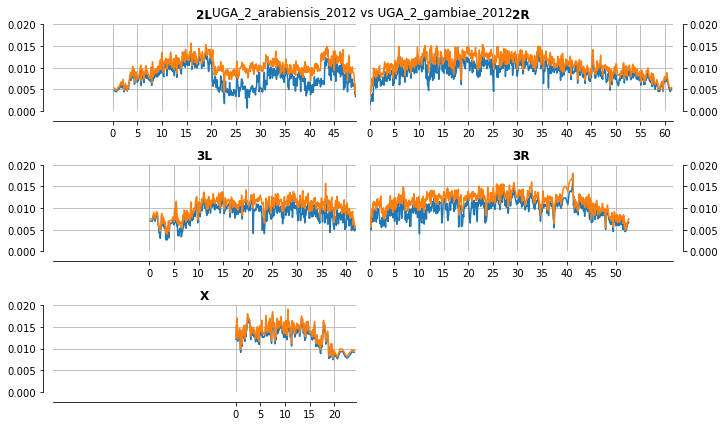

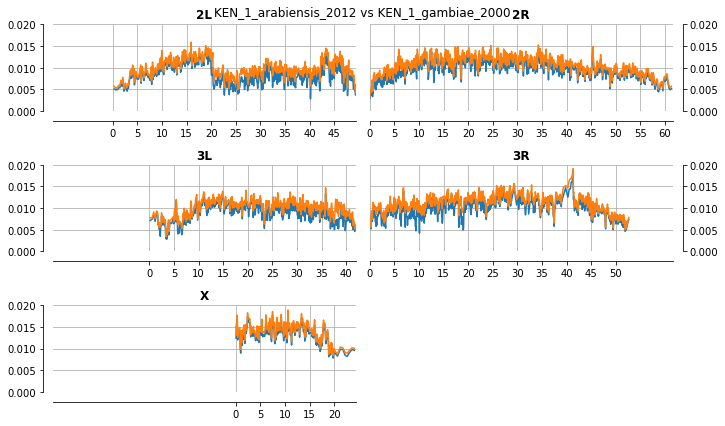

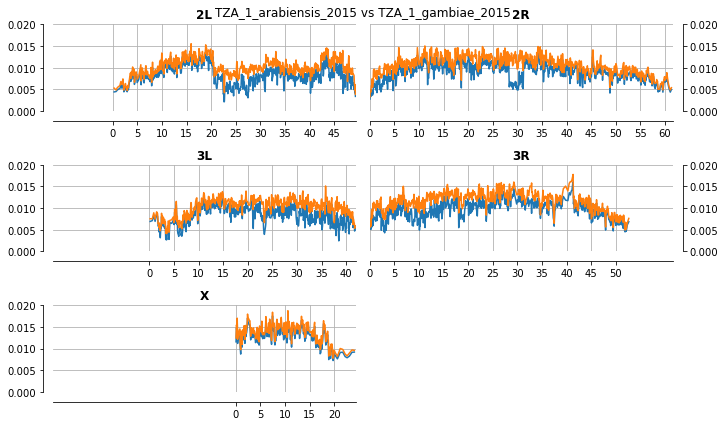

In [74]:
for arab_pop, gam_pop in sites_to_investigate:
    
    f = GenomeFigure(genome, chromosomes=chromosomes, figsize=(10, 6))
    f.apply(draw_introgression, data=pd_dict, location=arab_pop)
    f.fig.suptitle(arab_pop + " vs " + gam_pop)

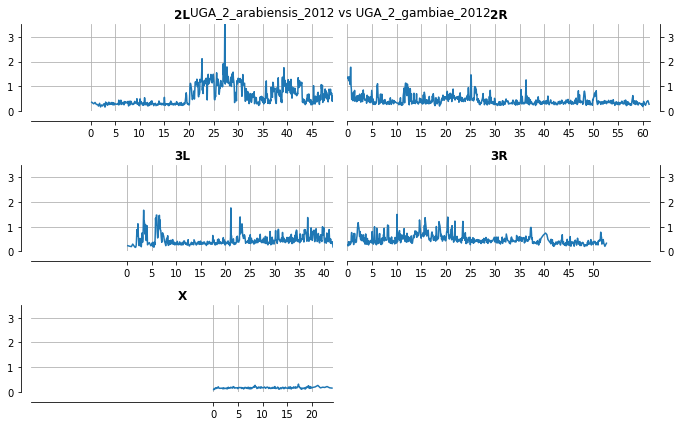

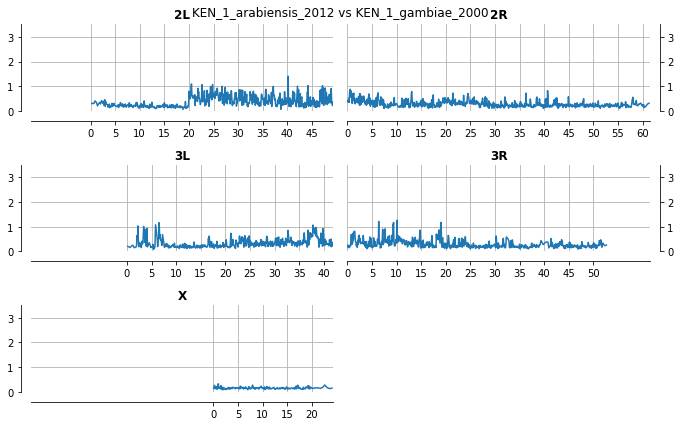

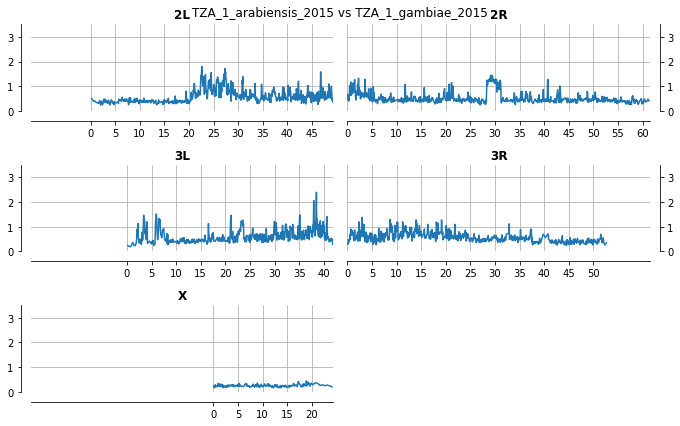

In [76]:
for arab_pop, gam_pop in sites_to_investigate:
    
    f = GenomeFigure(genome, chromosomes=chromosomes, figsize=(10, 6))
    f.apply(draw_introgression_relative, data=pd_dict, location=arab_pop)
    f.fig.suptitle(arab_pop + " vs " + gam_pop)